In [16]:
# Add Heatwave Root to PYTHONPATH
import sys; sys.path.append('../..')

from heatwave import ERA

import tensorflow as tf
from keras import Sequential
from keras.utils import Sequence
from keras.layers import *
from keras.regularizers import *

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import os

# EC-Earth x Convolutional Neural Network

## TODO
1. Common pitfall. An important point to make about the preprocessing is that any preprocessing statistics (e.g. the data mean) must only be computed on the training data, and then applied to the validation / test data. E.g. computing the mean and subtracting it from every image across the entire dataset and then splitting the data into train/val/test splits would be a mistake. Instead, the mean must be computed only over the training data and then subtracted equally from all splits (train/val/test).
2. A more recent paper on this topic, Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification by He et al., derives an initialization specifically for ReLU neurons, reaching the conclusion that the variance of neurons in the network should be 2.0/n. This gives the initialization w = np.random.randn(n) * sqrt(2.0/n), and is the current recommendation for use in practice in the specific case of neural networks with ReLU neurons.
3. Batch Normalization. A recently developed technique by Ioffe and Szegedy called Batch Normalization alleviates a lot of headaches with properly initializing neural networks by explicitly forcing the activations throughout a network to take on a unit gaussian distribution at the beginning of the training. The core observation is that this is possible because normalization is a simple differentiable operation. In the implementation, applying this technique usually amounts to insert the BatchNorm layer immediately after fully connected layers (or convolutional layers, as we’ll soon see), and before non-linearities. We do not expand on this technique here because it is well described in the linked paper, but note that it has become a very common practice to use Batch Normalization in neural networks. In practice networks that use Batch Normalization are significantly more robust to bad initialization. Additionally, batch normalization can be interpreted as doing preprocessing at every layer of the network, but integrated into the network itself in a differentiable manner. Neat!
4. Regularization!!!! : In practice, if you are not concerned with explicit feature selection, L2 regularization can be expected to give superior performance over L1.
5. Dropout! In practice: It is most common to use a single, global L2 regularization strength that is cross-validated. It is also common to combine this with dropout applied after all layers. The value of p=0.5 is a reasonable default, but this can be tuned on validation data.
6. Word of caution: It is important to note that the L2 loss is much harder to optimize than a more stable loss such as Softmax. Intuitively, it requires a very fragile and specific property from the network to output exactly one correct value for each input (and its augmentations). Notice that this is not the case with Softmax, where the precise value of each score is less important: It only matters that their magnitudes are appropriate. Additionally, the L2 loss is less robust because outliers can introduce huge gradients. When faced with a regression problem, first consider if it is absolutely inadequate to quantize the output into bins. For example, if you are predicting star rating for a product, it might work much better to use 5 independent classifiers for ratings of 1-5 stars instead of a regression loss. Classification has the additional benefit that it can give you a distribution over the regression outputs, not just a single output with no indication of its confidence. If you’re certain that classification is not appropriate, use the L2 but be careful: For example, the L2 is more fragile and applying dropout in the network (especially in the layer right before the L2 loss) is not a great idea.

In [44]:
# Helper Functions

def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc
    
def plot_roc(y_true, y_predict):
    # Plot Receiver Operating Characteristic Curve with Area Under Curve Score
    fpr, tpr, thr = roc_curve(y_true, y_predict)
    auc = roc_auc_score(y_true, y_predict)

    plt.title(f"ROC Curve - AUC: {auc:5.5f}")
    plt.plot([0, 1], [0, 1], linestyle="--", c="gray")
    plt.plot(fpr, tpr)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel("False Positive Ratio")
    plt.ylabel("True Positive Ratio")

## Loading & Transforming EC-Earth Data

In [124]:
DATA_ROOT = os.path.abspath("/Volumes/Samsung_T5/Thesis")
ECE_ROOT = os.path.join(DATA_ROOT, 'EC-Earth')
TMP_ROOT = os.path.join(DATA_ROOT, 'tmp')

SESSIONS = range(1, 17)
REPETITIONS = range(0, 24)
YEARS = [2039]
SHAPE = (160, 320)

SUMMER_START, SUMMER_END = 174, 234
SUMMER_LENGTH = SUMMER_END - SUMMER_START

LAG = 50
WINDOW = 14

def walk(sessions):
    assert all([session in SESSIONS for session in sessions])
    
    for session in sessions:
        for repetition in REPETITIONS:
            for i, year in enumerate(YEARS):
                year_code = f"{session:02d}{repetition*len(YEARS)+i:02d}"
                
                yield session, repetition, year, year_code
      
    
def load_T95(path) -> pd.DataFrame:
    df = pd.read_csv(path, names=["date", "series"])

    # Set Date as Index
    df["date"] = pd.PeriodIndex(df["date"], freq='D')
    df = df.set_index("date")

    return df
                

def load_sst(session, repetition, year):
    path = os.path.join(ECE_ROOT, f'tos_d_s{session:02d}', f'tos_d_ECEarth_PD_s{session:02d}r{repetition:02d}_{year:04d}.nc')
    return ERA(path, 'tos', index=[slice(SUMMER_START-LAG-WINDOW, SUMMER_END-LAG)], latitude_key='lat', longitude_key='lon', time_origin=f'{year}-01-01')


def moving_average(a, n) :
    ret = np.cumsum(a, axis=0)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n:] / n


class Anomaly(Sequence):
    def __init__(self, sessions, T95):
        self._sessions = sessions
        self._T95 = T95
        self._length = (len(sessions)*len(REPETITIONS)*len(YEARS))
    
        # Calculate SST mean, if not already buffered
        sst_mean_path = os.path.join(TMP_ROOT, "{}_mean_{}.npy".format('_'.join([str(s) for s in sessions]), LAG))
        if not os.path.exists(sst_mean_path):
            self._sst_mean = np.zeros((SUMMER_LENGTH+WINDOW, *SHAPE), np.float32)
            for i, (session, repetition, year, year_code) in enumerate(walk(sessions)):
                print(f"\rCalculating SST mean: {float(i)/self._length:1.0%}", end="")
                self._sst_mean += load_sst(session, repetition, year).data
            self._sst_mean /= self._length
            np.save(sst_mean_path, self._sst_mean)
            print()
        else:
            self._sst_mean = np.load(sst_mean_path)
            
        self._weight = np.mean([self._T95[f'{s:02d}00': f'{s:02d}99'].mean() for s in self._sessions])
        
    @property
    def weights(self):
        return {0: self._weight, 1: 1-self._weight}
    
    def get(self, session, repetition, year):
        return moving_average(load_sst(session, repetition, year).data - self._sst_mean, WINDOW)
    
    def __len__(self):
        return self._length
    
    def __getitem__(self, idx):
        residual, year_idx = divmod(idx, len(YEARS))
        session_idx, repetition = divmod(residual, len(REPETITIONS))
        year = YEARS[year_idx]
        session = self._sessions[session_idx]
        
        year_code = f"{session:02d}{repetition*len(YEARS)+year_idx:02d}"
        
        X = np.array(self.get(session, repetition, year)[..., None])
        y = self._T95[year_code].values.ravel()
        
            
        return X, y
    
    def __iter__(self):
        for i in range(len(self)):
            yield self[i]

In [56]:
T95 = load_T95(os.path.join(DATA_ROOT, 'heatwave_ECE.csv'))

In [57]:
T95_binary = (T95 > 1).astype(np.float32)
T95_ONE_HOT = pd.get_dummies(T95.values.ravel() > 1).astype(np.float32)
T95_ONE_HOT.index = T95.index

## Create Neural Network

In [153]:
ACTIVATION = tf.nn.relu
PADDING = 'same'
REGULARIZER = l2(0.015)

CONV2D_KWARGS = {'activation': ACTIVATION, 'padding': PADDING, 'kernel_regularizer': REGULARIZER}
    
model = Sequential()

model.add(AvgPool2D(1, input_shape=(*SHAPE, 1)))

model.add(Conv2D(8, 3, **CONV2D_KWARGS))
model.add(BatchNormalization())
model.add(Conv2D(8, 3, **CONV2D_KWARGS))
model.add(BatchNormalization())

model.add(MaxPool2D(2))
model.add(Dropout(0.5))

model.add(Conv2D(16, 3, **CONV2D_KWARGS))
model.add(BatchNormalization())
model.add(Conv2D(16, 3, **CONV2D_KWARGS))
model.add(BatchNormalization())

model.add(MaxPool2D(2))
model.add(Dropout(0.5))

model.add(Conv2D(32, 3, **CONV2D_KWARGS))
model.add(BatchNormalization())
model.add(Conv2D(32, 3, **CONV2D_KWARGS))
model.add(BatchNormalization())

model.add(MaxPool2D(2))
model.add(Dropout(0.5))

model.add(Conv2D(64, 3, **CONV2D_KWARGS))
model.add(BatchNormalization())
model.add(Conv2D(64, 3, **CONV2D_KWARGS))
model.add(BatchNormalization())

model.add(MaxPool2D(2))
model.add(Dropout(0.5))

model.add(Conv2D(128, 3, **CONV2D_KWARGS))
model.add(BatchNormalization())
model.add(Conv2D(128, 3, **CONV2D_KWARGS))
model.add(BatchNormalization())

model.add(MaxPool2D(2))
model.add(Dropout(0.25))
 
model.add(Flatten())

model.add(Dense(200, activation=tf.nn.relu))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1, activation=tf.nn.sigmoid, name="output"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', auc])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
average_pooling2d_46 (Averag (None, 160, 320, 1)       0         
_________________________________________________________________
conv2d_187 (Conv2D)          (None, 160, 320, 8)       80        
_________________________________________________________________
batch_normalization_231 (Bat (None, 160, 320, 8)       32        
_________________________________________________________________
conv2d_188 (Conv2D)          (None, 160, 320, 8)       584       
_________________________________________________________________
batch_normalization_232 (Bat (None, 160, 320, 8)       32        
_________________________________________________________________
max_pooling2d_117 (MaxPoolin (None, 80, 160, 8)        0         
_________________________________________________________________
dropout_161 (Dropout)        (None, 80, 160, 8)        0         
__________

In [154]:
TRAIN_SET = slice(0, 4)
VALIDATION_SET = slice(4, 6)
TEST_SET = slice(6, 8)

Y = T95_binary

train = Anomaly(SESSIONS[TRAIN_SET], Y)
validation = Anomaly(SESSIONS[VALIDATION_SET], Y)
test = Anomaly(SESSIONS[TEST_SET], Y)

## Train Neural Network

In [ ]:
model.fit_generator(generator=train, validation_data=validation, epochs=1, class_weight=train.weights)

Epoch 1/1
90/96 [===========================>..] - ETA: 54s - loss: 5.2847 - acc: 0.4963 - auc: 0.5100 


KeyboardInterrupt



In [145]:
model.evaluate_generator(test)

[0.767751393529276, 0.7288194467158368, 0.5236632625261942]

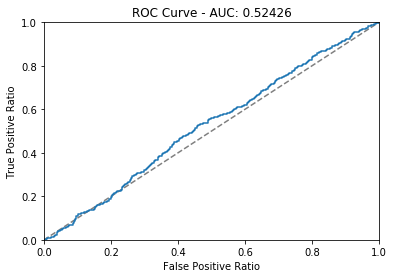

In [146]:
y_predict = model.predict_generator(test).ravel()
y_true = np.concatenate([y for X,y in test])

plot_roc(y_true, y_predict)

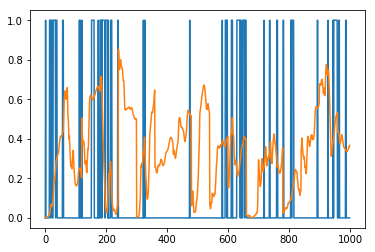

In [147]:
plt.plot(y_true[:1000])
plt.plot(y_predict[:1000])
plt.show()